# Transformer翻译项目

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#一.-建立Transformer模型的直观认识" data-toc-modified-id="一.-建立Transformer模型的直观认识-1">一. 建立Transformer模型的直观认识</a></span></li><li><span><a href="#二.-编码器部分（Encoder）" data-toc-modified-id="二.-编码器部分（Encoder）-2">二. 编码器部分（Encoder）</a></span><ul class="toc-item"><li><span><a href="#0.-先准备好输入的数据" data-toc-modified-id="0.-先准备好输入的数据-2.1">0. 先准备好输入的数据</a></span></li><li><span><a href="#1.-positional-encoding（即位置嵌入或位置编码）" data-toc-modified-id="1.-positional-encoding（即位置嵌入或位置编码）-2.2">1. positional encoding（即位置嵌入或位置编码）</a></span></li><li><span><a href="#2.-self-attention（自注意力机制）" data-toc-modified-id="2.-self-attention（自注意力机制）-2.3">2. self attention（自注意力机制）</a></span></li><li><span><a href="#3.-Attention-Mask" data-toc-modified-id="3.-Attention-Mask-2.4">3. Attention Mask</a></span></li><li><span><a href="#4.-Layer-Normalization-和残差连接" data-toc-modified-id="4.-Layer-Normalization-和残差连接-2.5">4. Layer Normalization 和残差连接</a></span></li><li><span><a href="#5.-Transformer-Encoder-整体结构" data-toc-modified-id="5.-Transformer-Encoder-整体结构-2.6">5. Transformer Encoder 整体结构</a></span></li></ul></li><li><span><a href="#三.-解码器部分（Decoder）" data-toc-modified-id="三.-解码器部分（Decoder）-3">三. 解码器部分（Decoder）</a></span></li><li><span><a href="#四.-Transformer模型" data-toc-modified-id="四.-Transformer模型-4">四. Transformer模型</a></span></li><li><span><a href="#五.-模型训练" data-toc-modified-id="五.-模型训练-5">五. 模型训练</a></span></li><li><span><a href="#六.-模型预测" data-toc-modified-id="六.-模型预测-6">六. 模型预测</a></span></li></ul></div>

在这份notebook当中，我们会(尽可能)实现 $Transformer$ 模型来完成翻译任务。  
（参考论文：$Attention\; Is\; All\; You\; Need$   https://arxiv.org/pdf/1706.03762.pdf ）
> **其中的`TODO`内容即为待完成的部分**

我们的数据集非常小，只有一万多个句子的训练数据，从结果来看训练出来的模型在测试集上的表现其实已经算还可以了。  
如果想得到更好的效果，则需要更大的数据量并进行更多的训练迭代次数，感兴趣（并且有硬件条件）的同学可以进行尝试。  

## 一. 建立Transformer模型的直观认识
  
首先来说一下**Transformer**和**LSTM**的最大区别，就是LSTM的训练是迭代（自回归）的，是一个接一个字的来，当前这个字过完LSTM单元，才可以进下一个字，而 $Transformer$ 的训练是并行了，就是所有字是全部同时训练的，这样就大大加快了计算效率，$Transformer$ 使用了位置嵌入$(positional \ encoding)$来理解语言的顺序，使用自注意力机制和全连接层来进行计算，这些后面都会详细讲解。   
  
$Transformer$ 模型主要分为**两大部分**，分别是**编码器（$Encoder$）**和**解码器（$Decoder$）**：  
- **编码器（$Encoder$）**负责把自然语言序列映射成为**隐藏层**(下图中**第2步**用九宫格比喻的部分)，含有自然语言序列的数学表达
- **解码器（$Decoder$）**再把隐藏层映射为自然语言序列，从而使我们可以解决各种问题，如情感分类、命名实体识别、语义关系抽取、摘要生成、机器翻译等等。

<img src="./imgs/intuition.jpg", width=650>

In [1]:
%%html

<img src="./imgs/intuition.jpg", width=660>
<img src="./imgs/transformer.png", width=660>

## 二. 编码器部分（Encoder）
  
  
我们会**重点介绍编码器的结构**，因为理解了编码器中的结构, 理解解码器就非常简单了。而且我们用编码器就能够完成一些自然语言处理中比较主流的任务, 如情感分类, 语义关系分析, 命名实体识别等。  
  
**编码器（$Encoder$）**部分, 即把**自然语言序列映射为隐藏层的数学表达的过程**。  

** 以下为一个Transformer Encoder Block结构示意图**
> 注意: 为方便查看, 下面各部分的内容分别对应着图中第1, 2, 3, 4个方框的序号：

<img src="./imgs/encoder.jpg", width=550>

### 0. 先准备好输入的数据

In [110]:
import os
import math
import copy
import time
import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
import tensorflow as tf
import tensorflow.nn as nn
from nltk import word_tokenize
from collections import Counter
# from torch.autograd import Variable

In [111]:
# 初始化参数设置
UNK = 0  # 未登录词的标识符对应的词典id
PAD = 1  # padding占位符对应的词典id
BATCH_SIZE = 64  # 每批次训练数据数量
EPOCHS = 200  # 训练轮数
LAYERS = 6  # transformer中堆叠的encoder和decoder block层数
H_NUM = 8  # multihead attention hidden个数
D_MODEL = 256  # embedding维数
D_FF = 1024  # feed forward第一个全连接层维数
DROPOUT = 0.1  # dropout比例
MAX_LENGTH = 60  # 最大句子长度

TRAIN_FILE = 'nmt/en-cn/train.txt'  # 训练集数据文件
DEV_FILE = "nmt/en-cn/dev.txt"  # 验证(开发)集数据文件
# SAVE_FILE = 'save/model.pt'  # 模型保存路径(注意如当前目录无save文件夹需要自己创建)
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [112]:
import numpy as np  
np.set_printoptions(threshold=np.inf)

In [113]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" 

In [114]:
def seq_padding(X, padding=0):
    """
    对一个batch批次(以单词id表示)的数据进行padding填充对齐长度
    """
    # 计算该批次数据各条数据句子长度
    L = [len(x) for x in X]
    # 获取该批次数据最大句子长度
    ML = max(L)
    # 对X中各条数据x进行遍历，如果长度短于该批次数据最大长度ML，则以padding id填充缺失长度ML-len(x)
    # （注意这里默认padding id是0，相当于是拿<UNK>来做了padding）
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])


class PrepareData:
    def __init__(self, train_file, dev_file):
        # 读取数据 并分词
        self.train_en, self.train_cn = self.load_data(train_file)
        self.dev_en, self.dev_cn = self.load_data(dev_file)

        # 构建单词表
        self.en_word_dict, self.en_total_words, self.en_index_dict = self.build_dict(self.train_en)
        self.cn_word_dict, self.cn_total_words, self.cn_index_dict = self.build_dict(self.train_cn)

        # id化
        self.train_en, self.train_cn = self.wordToID(self.train_en, self.train_cn, self.en_word_dict, self.cn_word_dict)
        self.dev_en, self.dev_cn = self.wordToID(self.dev_en, self.dev_cn, self.en_word_dict, self.cn_word_dict)

        # 划分batch + padding + mask
        self.train_data = self.splitBatch(self.train_en, self.train_cn, BATCH_SIZE)
        self.dev_data = self.splitBatch(self.dev_en, self.dev_cn, BATCH_SIZE)

    def load_data(self, path):
        """
        读取翻译前(英文)和翻译后(中文)的数据文件
        每条数据都进行分词，然后构建成包含起始符(BOS)和终止符(EOS)的单词(中文为字符)列表
        形式如：en = [['BOS', 'i', 'love', 'you', 'EOS'], ['BOS', 'me', 'too', 'EOS'], ...]
                cn = [['BOS', '我', '爱', '你', 'EOS'], ['BOS', '我', '也', '是', 'EOS'], ...]
        """
        en = []
        cn = []
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip().split('\t')

                en.append(["BOS"] + word_tokenize(line[0].lower()) + ["EOS"])
                cn.append(["BOS"] + word_tokenize(" ".join([w for w in line[1]])) + ["EOS"])
#         print(cn[63])
        return en, cn
    
    def build_dict(self, sentences, max_words=50000):
        """
        传入load_data构造的分词后的列表数据
        构建词典(key为单词，value为id值)
        """
        # 对数据中所有单词进行计数
        word_count = Counter()

        for sentence in sentences:
            for s in sentence:
                word_count[s] += 1
        # 只保留最高频的前max_words数的单词构建词典
        # 并添加上UNK和PAD两个单词，对应id已经初始化设置过
        ls = word_count.most_common(max_words)
        # 统计词典的总词数
        total_words = len(ls) + 2

        word_dict = {w[0]: index + 2 for index, w in enumerate(ls)}
        word_dict['UNK'] = UNK
        word_dict['PAD'] = PAD
        # 再构建一个反向的词典，供id转单词使用
        index_dict = {v: k for k, v in word_dict.items()}

        return word_dict, total_words, index_dict

    def wordToID(self, en, cn, en_dict, cn_dict, sort=True):
        """
        该方法可以将翻译前(英文)数据和翻译后(中文)数据的单词列表表示的数据
        均转为id列表表示的数据
        如果sort参数设置为True，则会以翻译前(英文)的句子(单词数)长度排序
        以便后续分batch做padding时，同批次各句子需要padding的长度相近减少padding量
        """
        # 计算英文数据条数
        length = len(en)
        # 将翻译前(英文)数据和翻译后(中文)数据都转换为id表示的形式
        out_en_ids = [[en_dict.get(w, 0) for w in sent] for sent in en]
        out_cn_ids = [[cn_dict.get(w, 0) for w in sent] for sent in cn]

        # 构建一个按照句子长度排序的函数
        def len_argsort(seq):
            """
            传入一系列句子数据(分好词的列表形式)，
            按照句子长度排序后，返回排序后原来各句子在数据中的索引下标
            """
            return sorted(range(len(seq)), key=lambda x: len(seq[x]))

        # 把中文和英文按照同样的顺序排序
        if sort:
            # 以英文句子长度排序的(句子下标)顺序为基准
            sorted_index = len_argsort(out_en_ids)
#             print(sorted_index[0])
#             print(out_cn_ids[sorted_index[0]])
            # 对翻译前(英文)数据和翻译后(中文)数据都按此基准进行排序
            out_en_ids = [out_en_ids[i] for i in sorted_index]
            out_cn_ids = [out_cn_ids[i] for i in sorted_index]
            
        return out_en_ids, out_cn_ids

    def splitBatch(self, en, cn, batch_size):
        """
        将以单词id列表表示的翻译前(英文)数据和翻译后(中文)数据
        按照指定的batch_size进行划分
        如果shuffle参数为True，则会对这些batch数据顺序进行随机打乱
        """
        # 在按数据长度生成的各条数据下标列表[0, 1, ..., len(en)-1]中
        # 每隔指定长度(batch_size)取一个下标作为后续生成batch的起始下标
        # 如果shuffle参数为True，则将这些各batch起始下标打乱
        # 存放各个batch批次的句子数据索引下标
            # 注意，起始下标最大的那个batch可能会超出数据大小
            # 因此要限定其终止下标不能超过数据大小
        
        # 按各batch批次的句子数据索引下标，构建实际的单词id列表表示的各batch句子数据
#         batches = []
#         for batch_index in batch_indexs:
#             # 按当前batch的各句子下标(数组批量索引)提取对应的单词id列表句子表示数据
#             batch_en = [en[index] for index in batch_index]  
#             batch_cn = [cn[index] for index in batch_index]
#             # 对当前batch的各个句子都进行padding对齐长度
#             # 维度为：batch数量×batch_size×每个batch最大句子长度
#             batch_cn = seq_padding(batch_cn)
#             batch_en = seq_padding(batch_en)
#             # 将当前batch的英文和中文数据添加到存放所有batch数据的列表中
#             batches.append(Batch(batch_en, batch_cn))
        X = np.zeros([len(en), MAX_LENGTH], np.int32)
        Y = np.zeros([len(cn), MAX_LENGTH], np.int32)
        for i, (x, y) in enumerate(zip(en, cn)):
            X[i] = np.lib.pad(x, [0, MAX_LENGTH - len(x)], 'constant', constant_values=(0, 0))
            Y[i] = np.lib.pad(y, [0, MAX_LENGTH - len(y)], 'constant', constant_values=(0, 0))
            num_batch = len(X) // BATCH_SIZE
        # convert to tensor
        X = tf.convert_to_tensor(X, tf.int32)
        Y = tf.convert_to_tensor(Y, tf.int32)
        # 构建数据集，打散，批量，并丢掉最后一个不够batch_size 的batch
        input_queues = tf.data.Dataset.from_tensor_slices((X, Y))
        input_queues = input_queues.shuffle(1000).batch(BATCH_SIZE, drop_remainder=True)
#         input_queues = input_queues.batch(BATCH_SIZE, drop_remainder=True)      
        return input_queues  #  shape=([batch_size, max_seq_len], [batch_size, max_seq_len])          
        

    

In [6]:
data = PrepareData(TRAIN_FILE, DEV_FILE)

注意，上述预处理中使用的 $Batch$ 类在后面的 $Encoder$ 内容的 $Attention\ Mask$ 部分定义

**Embeddings**  
  
与其他序列传导模型类似，我们使用learned embeddings将输入标记和输出标记转换为维度 $d_{model}$ 的向量。我们还使用通常学习的线性变换和softmax函数将 $Decoder$（解码器）的输出转换为预测的下一个标签的概率。  
  
在我们的模型中，我们在两个embedding层和pre-softmax线性变换层之间共享相同的权重矩阵。在其中的embedding层，我们会将这些权重乘以 $\sqrt{d_{model}}$ 。

In [115]:
class Embeddings(tf.keras.layers.Layer):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        # Embedding层
        self.lut =  tf.get_variable('lut',
                                       dtype=tf.float32,
                                       shape=[vocab, d_model],
                                       initializer=tf.contrib.layers.xavier_initializer())
#         self.lut = nn.Embedding(vocab, d_model)
        # Embedding维数
        self.d_model = d_model

    def call(self, x):
        # 返回x对应的embedding矩阵（需要乘以math.sqrt(d_model)）
        return nn.embedding_lookup(self.lut, X) * math.sqrt(self.d_model)

数据全部处理完成，现在我们开始理解和构建 $Transformer$ 模型

### 1. positional encoding（即位置嵌入或位置编码）

由于 $Transformer$ 模型**没有**循环神经网络的迭代操作，所以我们必须提供每个字的位置信息给 $Transformer$，才能识别出语言中的顺序关系。   
  
因此，我们定义一个位置嵌入的概念，也就是$positional \ encoding$，位置嵌入的维度为$[max \ sequence \ length，\ embedding \ dimension]$，嵌入的维度同词向量的维度，$max \ sequence \ length$属于超参数，指的是限定的最大单个句长。   
  
注意，我们一般以字为单位训练transformer模型，也就是说我们不用分词了，首先我们要初始化字向量为$[vocab \ size，\ embedding \ dimension]$，$vocab \ size$为总共的字库数量，$embedding \ dimension$为字向量的维度，也是每个字的数学表达。    
  
在论文 **attention is all you need**（ https://arxiv.org/pdf/1706.03762.pdf ）中使用了$sine$和$cosine$函数的线性变换来提供给模型位置信息：   
  
$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}}) \quad \quad PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})\tag{eq.1}$$  
  
上式中$pos$指的是句中字的位置，取值范围是$[0, \ max \ sequence \ length)$，$i$指的是词向量的维度，取值范围是$[0, \ embedding \ dimension)$，上面有$sin$和$cos$一组公式，也就是对应着$embedding \ dimension$维度的一组奇数和偶数的序号的维度，例如$0, 1$一组，$2, 3$一组，分别用上面的$sin$和$cos$函数做处理，从而产生不同的周期性变化，而位置嵌入在$embedding \ dimension$维度上随着维度序号增大，周期变化会越来越慢，而产生一种包含位置信息的纹理，就像论文原文中第六页讲的，位置嵌入函数的周期从$2 \pi$到$10000 * 2 \pi$变化，而每一个位置在$embedding \ dimension$维度上都会得到不同周期的$sin$和$cos$函数的取值组合，从而产生独一的纹理位置信息，模型从而学到位置之间的依赖关系和自然语言的时序特性。   

In [10]:
        return position / np.power(10000., 2. * (i // 2.) / np.float(d_model))

SyntaxError: 'return' outside function (<ipython-input-10-526c2fe1d488>, line 1)

In [116]:
# 导入依赖库
import matplotlib.pyplot as plt
import seaborn as sns

In [117]:
def positional_encoding(pos, d_model):
    '''
    :param pos: 词在句子中的位置，句子上的维族；（i是d_model上的维度）
    :param d_model: 隐状态的维度，相当于num_units
    :return: 位置编码 shape=[1, position_num, d_model], 其中第一个维度是为了匹配batch_size
    '''
    def get_angles(position, i):
        # 这里的i相当于公式里面的2i或2i+1
        # 返回shape=[position_num, d_model]
        return position / np.power(10000., 2. * (i // 2.) / np.float(d_model))

    angle_rates = get_angles(np.arange(pos)[:, np.newaxis],
                             np.arange(d_model)[np.newaxis, :])
    # 2i位置使用sin编码，2i+1位置使用cos编码
    pe_sin = np.sin(angle_rates[:, 0::2])
    pe_cos = np.cos(angle_rates[:, 1::2])
    pos_encoding = np.concatenate([pe_sin, pe_cos], axis=-1)
    pos_encoding = tf.cast(pos_encoding[np.newaxis, ...], tf.float32)
    return pos_encoding



(1, 50, 512)


Text(0.5, 0, 'Depth')

(0, 512)

Text(0, 0.5, 'Position')

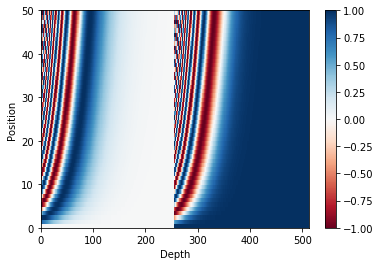

In [118]:
# 演示positional_encoding
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

可见，这里首先是按照最大长度max_len生成一个位置，而后根据公式计算出所有的向量，在forward函数中根据长度取用即可，非常方便。  
  
> 注意要设置requires_grad=False，因其不参与训练。

下面画一下位置嵌入，可见纵向观察，随着$embedding \ dimension$增大，位置嵌入函数呈现不同的周期变化。

### 2. self attention（自注意力机制）

<img src="./imgs/attention_0.jpg", width=600>
<img src="./imgs/attention_1.jpg", width=600>

**除以$\sqrt{d_k}$的解释**  
  
假设 $q$ 和 $k$ 是独立的随机变量，平均值为 0，方差 1，这样他们的点积后形成的注意力矩阵为 $q⋅k=\sum_{i=1}^{d_k}{q_i k_i}$，均值为 0 但方差放大为 $d_k$ 。为了抵消这种影响，我们用$\sqrt{d_k}$来缩放点积，可以使得Softmax归一化时结果更稳定（不至于点积后得到注意力矩阵的值差别太大），以便反向传播时获取平衡的梯度

In [119]:
'''*************** 第一部分: Scaled dot-product attention ***************'''
def scaled_dot_product_attention(q, k, v, mask):
    '''attention(Q, K, V) = softmax(Q * K^T / sqrt(dk)) * V'''
#     tf.print(mask)
    # query 和 Key相乘
    matmul_qk = tf.matmul(q, k, transpose_b=True)
#     tf.print(matmul_qk)
    # 使用dk进行缩放
    dk = tf.cast(tf.shape(q)[-1], tf.float32)
    scaled_attention =matmul_qk / tf.math.sqrt(dk)
    # 掩码mask
    if mask is not None:
        # 这里将mask的token乘以-1e-9，这样与attention相加后，mask的位置经过softmax后就为0
        # padding位置 mask=1
        scaled_attention += mask * -1e9
#         tf.print(scaled_attention) 
    # 通过softmax获取attention权重, mask部分softmax后为0
    attention_weights = tf.nn.softmax(scaled_attention)  # shape=[batch_size, seq_len_q, seq_len_k]
#     print('attention_weights000000000000000000')
#     tf.print(attention_weights)    
    # 乘以value
    outputs = tf.matmul(attention_weights, v)  # shape=[batch_size, seq_len_q, depth]
    return outputs, attention_weights


'*************** 第一部分: Scaled dot-product attention ***************'

In [81]:
a = 2
a += 1 * -1e9
a

-999999998.0

In [120]:
'''*************** 第二部分: Multi-Head Attention ***************'''
'''
multi-head attention包含3部分： - 线性层与分头 - 缩放点积注意力 - 头连接 - 末尾线性层
每个多头注意块有三个输入; Q（查询），K（密钥），V（值）。 它们通过第一层线性层并分成多个头。
注意:点积注意力时需要使用mask， 多头输出需要使用tf.transpose调整各维度。
Q，K和V不是一个单独的注意头，而是分成多个头，因为它允许模型共同参与来自不同表征空间的不同信息。
在拆分之后，每个头部具有降低的维度，总计算成本与具有全维度的单个头部注意力相同。
'''
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        # d_model必须可以正确分成多个头
        assert d_model % num_heads == 0
        # 分头之后维度
        self.depth = d_model // num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        # 分头，将头个数的维度，放到seq_len前面 x输入shape=[batch_size, seq_len, d_model]
        x = tf.reshape(x, [batch_size, -1, self.num_heads, self.depth])
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]
        # 分头前的前向网络，根据q,k,v的输入，计算Q, K, V语义
        q = self.wq(q)  # shape=[batch_size, seq_len_q, d_model]
        k = self.wq(k)
        v = self.wq(v)
        # 分头
        q = self.split_heads(q, batch_size)  # shape=[batch_size, num_heads, seq_len_q, depth]
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        # 通过缩放点积注意力层
        # scaled_attention shape=[batch_size, num_heads, seq_len_q, depth]
        # attention_weights shape=[batch_size, num_heads, seq_len_q, seq_len_k]
#         print('where')        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # 把多头维度后移
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # shape=[batch_size, seq_len_q, num_heads, depth]
        # 把多头合并
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) # shape=[batch_size, seq_len_q, d_model]
        # 全连接重塑
        output = self.dense(concat_attention)
        return output, attention_weights

'*************** 第二部分: Multi-Head Attention ***************'

'\nmulti-head attention包含3部分： - 线性层与分头 - 缩放点积注意力 - 头连接 - 末尾线性层\n每个多头注意块有三个输入; Q（查询），K（密钥），V（值）。 它们通过第一层线性层并分成多个头。\n注意:点积注意力时需要使用mask， 多头输出需要使用tf.transpose调整各维度。\nQ，K和V不是一个单独的注意头，而是分成多个头，因为它允许模型共同参与来自不同表征空间的不同信息。\n在拆分之后，每个头部具有降低的维度，总计算成本与具有全维度的单个头部注意力相同。\n'

In [60]:
# 测试multi-head attention
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))
output, att = temp_mha(y, y, y, None)
print(output.shape, att.shape)

(1, 60, 512) (1, 8, 60, 60)


参数里面的 $h$ 和 $d_{model}$ 分别表示注意力头的个数，以及模型的隐层单元数。  
  
另外在 $\_\_init\_\_$ 函数中，我们定义了 $self.linears = clones(nn.Linear(d_{model},\; d_{model}),\; 4),\; clone(x,\; N)$ 即为深拷贝N份，这里定义了4个全连接函数，实际上是3+1，其中的3个分别是Q、K和V的变换矩阵，最后一个是用于最后将 $h$ 个多头注意力矩阵concat之后进行变换的矩阵。  
  
在 $forward$ 函数中，是首先将 $query$、$key$ 和 $value$ 进行相应的变换，然后需要经过 $attention$ 这个函数的计算，这个函数实际上就是论文中“Scaled Dot-Product Attention”这个模块的计算

### 3. Attention Mask

<img src="./imgs/attention_mask.jpg", width=750>

注意, 在上面$self \ attention$的计算过程中, 我们通常使用$mini \ batch$来计算, 也就是一次计算多句话, 也就是$X$的维度是$[batch \ size, \ sequence \ length]$, $sequence \ length$是句长, 而一个$mini \ batch$是由多个不等长的句子组成的, 我们就需要按照这个$mini \ batch$中最大的句长对剩余的句子进行补齐长度, 我们一般用$0$来进行填充, 这个过程叫做$padding$.   
  
但这时在进行$softmax$的时候就会产生问题, 回顾$softmax$函数$\sigma (\mathbf {z} )_{i}={\frac {e^{z_{i}}}{\sum _{j=1}^{K}e^{z_{j}}}}$, $e^0$是1, 是有值的, 这样的话$softmax$中被$padding$的部分就参与了运算, 就等于是让无效的部分参与了运算, 会产生很大隐患, 这时就需要做一个$mask$让这些无效区域不参与运算, 我们一般给无效区域加一个很大的负数的偏置, 也就是:  
  
$$z_{illegal} = z_{illegal} + bias_{illegal}$$
$$bias_{illegal} \to -\infty$$
$$e^{z_{illegal}} \to 0 $$  
  
经过上式的$masking$我们使无效区域经过$softmax$计算之后几乎为$0$, 这样就避免了无效区域参与计算.

在 $Transformer$ 里面，$Encoder$ 和 $Decoder $的 $Attention$ 计算都需要相应的 $Mask$ 处理，但功能却不同。  
  
在 $Encoder$ 中，就如上述介绍的，$Mask$ 就是为了让那些在一个 $batch$ 中长度较短的序列的 $padding$ 部分不参与 $Attention$ 的计算。因此我们定义一个 $Batch$ 批处理对象，它包含用于训练的 $src$（翻译前）和 $trg$（翻译后）句子，以及构造其中的 $Mask$ 掩码。  
  
**加了 $Mask$ 的 $Attention$ 原理如图（另附 $Multi\text{-}Head\ Attention$ ）：**  
> 注意：这里的 $Attention\ Mask$ 是加在 $Scale$ 和 $Softmax$ 之间  
  
<img src="./imgs/attention_mask2.jpg", width=550>

### 4. Layer Normalization 和残差连接

1). **LayerNorm**:   
  
$Layer Normalization$的作用是把神经网络中隐藏层归一为标准正态分布, 也就是 $i.i.d$（独立同分布）, 以起到加快训练速度, 加速收敛的作用:
$$\mu_{i}=\frac{1}{m} \sum^{m}_{i=1}x_{ij}$$  
  
上式中以矩阵的行$(row)$为单位求均值;  
  
$$\sigma^{2}_{j}=\frac{1}{m} \sum^{m}_{i=1}
(x_{ij}-\mu_{j})^{2}$$  
  
上式中以矩阵的行$(row)$为单位求方差;  
  
$$LayerNorm(x)=\alpha \odot \frac{x_{ij}-\mu_{i}}
{\sqrt{\sigma^{2}_{i}+\epsilon}} + \beta \tag{eq.5}$$  
  
然后用**每一行**的**每一个元素**减去**这行的均值**, 再除以**这行的标准差**, 从而得到归一化后的数值, $\epsilon$是为了防止除$0$;   
之后引入两个**可训练参数**$\alpha, \ \beta$来弥补归一化的过程中损失掉的信息, 注意$\odot$表示元素相乘而不是点积, 我们一般初始化$\alpha$为全$1$, 而$\beta$为全$0$.

2). **残差连接**:   
  
我们在上一步得到了经过注意力矩阵加权之后的$V$, 也就是$Attention(Q, \ K, \ V)$, 我们对它进行一下转置, 使其和$X_{embedding}$的维度一致, 也就是$[batch \ size, \ sequence \ length, \ embedding \ dimension]$, 然后把他们加起来做残差连接, 直接进行元素相加, 因为他们的维度一致:   
  
$$X_{embedding} + Attention(Q, \ K, \ V)$$  
  
在之后的运算里, 每经过一个模块的运算, 都要把运算之前的值和运算之后的值相加, 从而得到残差连接, 训练的时候可以使梯度直接走捷径反传到最初始层:  
  
$$X + SubLayer(X) \tag{eq. 6}$$  
  
> **注意：这里我们对$SubLayer(X)$一般会进行dropout后再与X连接，即　$X + Dropout(SubLayer(X))$**

In [121]:
class LayerNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-8, **kwargs):
        super(LayerNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma',
                                     shape=input_shape[-1:],
                                     initializer=tf.ones_initializer(),
                                     trainable=True)
        self.beta = self.add_weight(name='beta',
                                    shape=input_shape[-1:],
                                    initializer=tf.zeros_initializer(),
                                    trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x): # x shape=[batch_size, seq_len, d_model]
        mean = tf.keras.backend.mean(x, axis=-1, keepdims=True)
        std = tf.keras.backend.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.epsilon) + self.beta

In [122]:
def point_wise_feed_forward(d_model, diff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(diff, activation=tf.nn.relu),
        tf.keras.layers.Dense(d_model)
    ])

以上是 $LayerNormalization$ 的实现，其实PyTorch里面已经集成好了nn.LayerNorm，这里实现出来是为了学习其中的原理。而实际中，为了代码简洁，可以直接使用PyTorch里面实现好的函数。

In [ ]:
'''encoder layer:
每个编码层包含以下子层 - Multi-head attention（带掩码） - Point wise feed forward networks
每个子层中都有残差连接，并最后通过一个正则化层。残差连接有助于避免深度网络中的梯度消失问题。 
每个子层输出是LayerNorm(x + Sublayer(x))，规范化是在d_model维的向量上。Transformer一共有n个编码层。
'''

In [123]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward(d_model, dff)
        self.layernorm1 = LayerNormalization()
        self.layernorm2 = LayerNormalization()
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    def call(self, inputs, training, mask):
        # multi head attention (encoder时Q = K = V)
        att_output, _ = self.mha(inputs, inputs, inputs, mask)
        att_output = self.dropout1(att_output, training=training)
        output1 = self.layernorm1(inputs + att_output)  # shape=[batch_size, seq_len, d_model]
        # feed forward network
        ffn_output = self.ffn(output1)
        ffn_output = self.dropout2(ffn_output, training=training)
        output2 = self.layernorm2(output1 + ffn_output)  # shape=[batch_size, seq_len, d_model]
        return output2

In [ ]:
# class SublayerConnection(nn.Module):
#     """
#     SublayerConnection的作用就是把Multi-Head Attention和Feed Forward层连在一起
#     只不过每一层输出之后都要先做Layer Norm再残差连接
#     """
#     def __init__(self, size, dropout):
#         super(SublayerConnection, self).__init__()
#         self.norm = LayerNorm(size)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x, sublayer):
#         # TODO: 请利用init中的成员变量实现LayerNorm和残差连接的功能
#         # 返回Layer Norm和残差连接后结果
#         return 

### 5. Transformer Encoder 整体结构

经过上面4个步骤, 我们已经基本了解到来$transformer$编码器的主要构成部分, 我们下面用公式把一个$transformer \ block$的计算过程整理一下:    
  
1). **字向量与位置编码:**   
$$X = EmbeddingLookup(X) + PositionalEncoding \tag{eq.2}$$
$$X \in \mathbb{R}^{batch \ size  \ * \  seq. \ len. \  * \  embed. \ dim.} $$  
  
2). **自注意力机制:**   
$$Q = Linear(X) = XW_{Q}$$ 
$$K = Linear(X) = XW_{K} \tag{eq.3}$$
$$V = Linear(X) = XW_{V}$$
$$X_{attention} = SelfAttention(Q, \ K, \ V) \tag{eq.4}$$  
  
3). **残差连接与$Layer \ Normalization$**
$$X_{attention} = LayerNorm(X_{attention}) \tag{eq. 5}$$
$$X_{attention} = X + X_{attention} \tag{eq. 6}$$  
  
4). **$FeedForward$，其实就是两层线性映射并用激活函数（比如说$ReLU$）激活：**   
$$X_{hidden} = Linear(Activate(Linear(X_{attention}))) \tag{eq. 7}$$  
  
5). **重复3).:**
$$X_{hidden} = LayerNorm(X_{hidden})$$
$$X_{hidden} = X_{attention} + X_{hidden}$$
$$X_{hidden} \in \mathbb{R}^{batch \ size  \ * \  seq. \ len. \  * \  embed. \ dim.} $$

$Feed Forward$（前馈网络）层其实就是两层线性映射并用激活函数激活

$Encoder$ 由 $N=6$ 个相同的层组成。

In [124]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_layers, num_heads, dff,
                 input_vocab_size, max_seq_len, dropout_rate=0.1):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        self.emb = tf.keras.layers.Embedding(input_vocab_size, d_model)  # shape=[batch_size, seq_len, d_model]
        self.pos_encoding = positional_encoding(max_seq_len, d_model)  # shape=[1, max_seq_len, d_model]
        self.encoder_layer = [EncoderLayer(d_model, num_heads, dff, dropout_rate)
                              for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
    def call(self, inputs, training, mask):
        # 输入部分；inputs shape=[batch_size, seq_len]
        seq_len = inputs.shape[1]  # 句子真实长度
        word_embedding = self.emb(inputs)  # shape=[batch_size, seq_len, d_model]
        word_embedding *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        emb= word_embedding + self.pos_encoding[:, :seq_len, :]
        x = self.dropout(emb, training=training)
        for i in range(self.num_layers):
            x = self.encoder_layer[i](x, training, mask)
        return x  # shape=[batch_size, seq_len, d_model]

In [125]:
# 编码器测试
sample_encoder = Encoder(512, 2, 8, 1024, 5000, 200)
sample_encoder_output = sample_encoder(tf.random.uniform((64, 120)), False, None)
print(sample_encoder_output.shape)

(64, 120, 512)


每层 $Encoder\ Block$ 都有两个子层组成。第一个子层实现了“多头”的 $Self\text{-}attention$，第二个子层则是一个简单的 $Position\text{-}wise$ 的全连接前馈网络。

In [ ]:
# class EncoderLayer(nn.Module):
#     def __init__(self, size, self_attn, feed_forward, dropout):
#         super(EncoderLayer, self).__init__()
#         self.self_attn = self_attn
#         self.feed_forward = feed_forward
#         # SublayerConnection的作用就是把multi和ffn连在一起
#         # 只不过每一层输出之后都要先做Layer Norm再残差连接
#         self.sublayer = clones(SublayerConnection(size, dropout), 2)
#         # d_model
#         self.size = size

#     def forward(self, x, mask):
#         # 将embedding层进行Multi head Attention
#         x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
#         # 注意到attn得到的结果x直接作为了下一层的输入
#         return self.sublayer[1](x, self.feed_forward)

## 三. 解码器部分（Decoder）

<img src="./imgs/decoder.jpg", width=550>

接着来看 $Decoder$ 部分（右半部分），它同样也是由 $N$ 层（在论文中，仍取 $N=6$ ）堆叠起来。  
> 对于其中的每一层，除了与 $Encoder$ 中相同的 $self\text{-}attention$ 及 $Feed Forward$ 两层之外，还在中间插入了一个传统的 $Encoder\text{-}Decoder$ 框架中的 $context\text{-}attention$ 层（上图中的$sub\text{-}layer\ 2$），即将 $Decoder$ 的输出作为 $query$ 去查询 $Encoder$ 的输出，同样用的是 $Multi\text{-}Head\ Attention$ ，使得在 $Decode$ 的时候能看到 $Encoder$ 的所有输出。  
  
这里明确一下 **$Decoder$ 的输入输出和解码过程：**

- 输入：$Encoder$ 的输出 & 对应 $i-1$ 位置 $Decoder$ 的输出。所以中间的 $Attention$ 不是 $Self\text{-}Attention$ ，它的 $K$，$V$ 来自 $Encoder$ ，Q来自上一位置 $Decoder$ 的输出
- 输出：对应 $i$ 位置的输出词的概率分布
- 解码：这里要特别注意一下，编码可以并行计算，一次性全部encoding出来，但解码不是一次把所有序列解出来的，而是像rnn一样一个一个解出来的，因为要用上一个位置的输入当作 $Attention$ 的 $query$

这里 ** $Encoder$ 和 $Decoder$ 的 $Attention$ 的区别如下图所示**  
<img src="./imgs/attention.png", width=550>

In [126]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward(d_model, dff)
        self.layernorm1 = LayerNormalization()
        self.layernorm2 = LayerNormalization()
        self.layernorm3 = LayerNormalization()
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout3 = tf.keras.layers.Dropout(dropout_rate)
    def call(self, inputs, encoder_out, training, look_ahead_mask, padding_mask):
#         tf.print(look_ahead_mask)
        # masked multi-head attention: Q = K = V
#         print('sassssssssssssssssssssssssssasssssssss')       
        att_out1, att_weight1 = self.mha1(inputs, inputs, inputs, look_ahead_mask)
#         print('sassssssssssssssssssssssssssasssssssss')
#         tf.print(att_weight1)
        att_out1 = self.dropout1(att_out1, training=training)
        att_out1 = self.layernorm1(inputs + att_out1)
        # multi-head attention: Q=att_out1, K = V = encoder_out
        att_out2, att_weight2 = self.mha2(att_out1, encoder_out, encoder_out, padding_mask)
        att_out2 = self.dropout2(att_out2, training=training)
        att_out2 = self.layernorm2(att_out1 + att_out2)
        # feed forward network
        ffn_out = self.ffn(att_out2)
        ffn_out = self.dropout3(ffn_out, training=training)
        output = self.layernorm3(att_out2 + ffn_out)
        return output, att_weight1, att_weight2

In [127]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_layers, num_heads, dff,
                 target_vocab_size, max_seq_len, dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.seq_len = tf.shape
        self.d_model = d_model
        self.num_layers = num_layers
        self.word_embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_seq_len, d_model)
        self.decoder_layers = [DecoderLayer(d_model, num_heads, dff, dropout_rate)
                               for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
    def call(self, inputs, encoder_out, training, look_ahead_mask, padding_mask):
#         tf.print(look_ahead_mask)
#         tf.print(padding_mask)

        seq_len = inputs.shape[1]
        attention_weights = {}
        word_embedding = self.word_embedding(inputs)
        word_embedding *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        emb = word_embedding + self.pos_encoding[:, :seq_len, :]
        x = self.dropout(emb, training=training)
        for i in range(self.num_layers):
            x, att1, att2 = self.decoder_layers[i](x, encoder_out, training,
                                                   look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_att_w1'.format(i+1)] = att1
            attention_weights['decoder_layer{}_att_w2'.format(i + 1)] = att2
#             tf.print(att1)
#             tf.print(att2)
        return x, attention_weights

明确了解码过程之后最上面的图就很好懂了，这里主要的不同就是新加的另外要说一下新加的attention多加了一个 $subsequent\_mask$ ，因为训练时的output都是ground truth，这样可以确保预测第 $i$ 个位置时不会接触到未来的信息，具体解释如下。

对于 $Encoder$ 中 $src$ 的 $mask$ 方式就比较简单，直接把 $pad$ 部分给 $mask$ 掉即可。  
但对于 $Decoder$ 中 $trg$ 的 $mask$ 计算略微复杂一些，不仅需要把 $pad$ 部分 $mask$ 掉，还需要进行一个 $subsequent\_mask$ 的操作。  
即作为 $decoder$，在预测当前步的时候，是不能知道后面的内容的，即 $attention$ 需要加上 $mask$，将当前步之后的分数全部置为$-\infty$，然后再计算 $softmax$，以防止发生数据泄露。这种 $Masked$ 的 $Attention$ 是考虑到输出 $Embedding$ 会偏移一个位置，确保了生成位置 $i$ 的预测时，仅依赖小于 $i$ 的位置处的已知输出，相当于把后面不该看到的信息屏蔽掉。  

In [22]:
# 解码器测试
sample_decoder = Decoder(512, 2, 8, 1024, 5000, 200)
sample_decoder_output, attn = sample_decoder(tf.random.uniform((64, 100)),
                                             sample_encoder_output, False, None, None)
print(sample_decoder_output.shape)
print(attn['decoder_layer1_att_w2'].shape)

NameError: name 'sample_encoder_output' is not defined

In [129]:
def create_padding_mask(seq):
    '''为了避免输入中padding的token对句子语义的影响，需要将padding位mask掉，
    原来为0的padding项的mask输出为1; encoder和decoder过程都会用到'''
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # 扩充维度以便于使用attention矩阵;seq输入shape=[batch_size, seq_len]；输出shape=[batch_siz, 1, 1, seq_len]
    return seq[:, np.newaxis, np.newaxis, :]

# look-ahead mask
def create_look_ahead_mask(size):
    '''用于对未预测的token进行掩码 这意味着要预测第三个单词，只会使用第一个和第二个单词。
    要预测第四个单词，仅使用第一个，第二个和第三个单词，依此类推。只有decoder过程用到'''
    # 产生一个上三角矩阵，上三角的值全为0。把这个矩阵作用在每一个序列上，就可以达到我们的目的。
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # shape=[seq_len, seq_len]

def create_mask(inputs, targets):
    # 编码器只有padding_mask
    encoder_padding_mask = create_padding_mask(inputs)
    # 解码器decoder_padding_mask,用于第二层multi-head attention
    decoder_padding_mask = create_padding_mask(inputs)
    # seq_mask mask掉未预测的词
    seq_mask = create_look_ahead_mask(tf.shape(targets)[1])
    # decoder_targets_padding_mask 解码层的输入padding mask
    decoder_targets_padding_mask = create_padding_mask(targets)
    # 合并解码层mask，用于第一层masked multi-head attention
    look_ahead_mask = tf.maximum(decoder_targets_padding_mask, seq_mask)
    return encoder_padding_mask, look_ahead_mask, decoder_padding_mask

我们可视化一下 $subsequent\_mask$ 矩阵的形式，直观进行理解。  
这里的 $Attention mask$ 图显示了允许每个目标词（行）查看的位置（列）。在训练期间，当前解码位置的词不能 $Attend$ 到后续位置的词。  
  
> 这里是给定一个序列长度size，生成一个下三角矩阵，在主对角线右上的都是 False，其示意图如下：  
<img src="./imgs/subsequent_mask.png", width=450>  
就是在decoder层的self-Attention中，由于生成 $s_i$ 时， $s_{i+1}$ 并没有产生，所以不能有 $s_i$ 和 $s_{i+1}$ 的关联系数，即只有下三角矩阵有系数，即下图中**`黄色部分`**。

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

## 四. Transformer模型
  
最后，我们把 $Encoder$ 和 $Decoder$ 组成 $Transformer$ 模型

In [130]:
'''Transformer包含编码器、解码器和最后的线性层，解码层的输出经过线性层后得到Transformer的输出'''
class Transformer(tf.keras.Model):
    def __init__(self, d_model, num_layers, num_heads, dff,
                 input_vocab_size, target_vocab_size, max_seq_len, dropout_rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(d_model, num_layers, num_heads, dff, input_vocab_size, max_seq_len, dropout_rate)
        self.decoder = Decoder(d_model, num_layers, num_heads, dff, target_vocab_size, max_seq_len, dropout_rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    def call(self, inputs, targets, training, encoder_padding_mask,
             look_ahead_mask, decoder_padding_mask):
        # 首先encoder过程，输出shape=[batch_size, seq_len_input, d_model]
        encoder_output = self.encoder(inputs, training, encoder_padding_mask)
#         tf.print(encoder_output)
        # 再进行decoder, 输出shape=[batch_size, seq_len_target, d_model]
        decoder_output, att_weights = self.decoder(targets, encoder_output, training,
                                                   look_ahead_mask, decoder_padding_mask)
        # 最后映射到输出层
        final_out = self.final_layer(decoder_output) # shape=[batch_size, seq_len_target, target_vocab_size]
        return final_out, att_weights

'Transformer包含编码器、解码器和最后的线性层，解码层的输出经过线性层后得到Transformer的输出'

In [131]:
# transformer测试
sample_transformer = Transformer(
num_layers=2, d_model=512, num_heads=8, dff=1024,
input_vocab_size=8500, target_vocab_size=8000, max_seq_len=120
)
temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))
fn_out, att = sample_transformer(temp_input, temp_target, training=False,
                              encoder_padding_mask=None,
                               look_ahead_mask=None,
                               decoder_padding_mask=None,
                              )
# print(fn_out.shape)
# print(att['decoder_layer1_att_w1'].shape)
# print(att['decoder_layer1_att_w2'].shape)

In [ ]:
# print(fn_out.shape)
# print(att['decoder_layer1_att_w1'].shape)
# print(att['decoder_layer1_att_w2'].shape)

In [132]:
def create_look_ahead_mask(size):
    '''用于对未预测的token进行掩码 这意味着要预测第三个单词，只会使用第一个和第二个单词。
    要预测第四个单词，仅使用第一个，第二个和第三个单词，依此类推。只有decoder过程用到'''
    # 产生一个上三角矩阵，上三角的值全为0。把这个矩阵作用在每一个序列上，就可以达到我们的目的。
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # shape=[seq_len, seq_len]
create_look_ahead_mask(10)

<tf.Tensor: id=658402, shape=(10, 10), dtype=float32, numpy=
array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

**定义设置超参并连接完整模型的函数**

## 五. 模型训练

**标签平滑**

在训练期间，我们采用了值$\epsilon_{ls}=0.1$的标签平滑（参见： https://arxiv.org/pdf/1512.00567.pdf ），其实还是从$Computer\; Vision$上搬过来的，具体操作可以看下面的代码实现，**在这里不作为重点**。  
  
这种做法提高了困惑度，因为模型变得更加不确定，但提高了准确性和BLEU分数。  
>我们使用 $KL\; div\; loss$（KL散度损失）实现标签平滑。  
对于输出的分布，从原始的 $one\text{-}hot$ 分布转为在groundtruth上使用一个confidence值，而后其他的所有非groudtruth标签上采用 $\frac{1 - confidence}{odim - 1}$ 作为概率值进行平滑。

In [ ]:
class LabelSmoothing(nn.Module):
    """标签平滑处理"""
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

这里的size是输出词表的大小，smoothing是用于分摊在非groundtruth上面的概率值。

在这里，我们可以看到标签平滑的示例。

In [ ]:
# Label smoothing的例子
crit = LabelSmoothing(5, 0, 0.4)  # 设定一个ϵ=0.4
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
print(crit.true_dist)
plt.imshow(crit.true_dist)

如果对给定的选择非常有信心，标签平滑实际上会开始惩罚模型。

In [24]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    #print(predict)
    return crit(Variable(predict.log()), Variable(torch.LongTensor([1]))).item()

plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

NameError: name 'LabelSmoothing' is not defined

**计算损失**

In [136]:

# 损失和准确率
'''由于目标序列是填充的，因此在计算损耗时应用填充掩码很重要。 padding的掩码为0，没padding的掩码为1'''
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_fun(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    loss_ = loss_object(y_true, y_pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)
# 用于记录损失和准确率
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

'由于目标序列是填充的，因此在计算损耗时应用填充掩码很重要。 padding的掩码为0，没padding的掩码为1'

In [137]:
a = [0,0,1,0]
b = [1,0,0,0]
loss_fun(a,b)

AttributeError: 'list' object has no attribute 'shape'

**optimizer优化器**

论文里面提到了他们用的优化器，是以$\beta_1=0.9、\beta_2=0.98$ 和 $\epsilon = 10^{−9}$ 的 $Adam$ 为基础，而后使用一种warmup的学习率调整方式来进行调节。  
具体公式如下：  
  
$$ lrate = d^{−0.5}_{model}⋅min(step\_num^{−0.5},\; step\_num⋅warmup\_steps^{−1.5})$$  

基本上就是用一个固定的 $warmup\_steps$ **先进行学习率的线性增长（热身）**，而后到达 $warmup\_steps$ 之后会随着 $step\_num$ 的增长，以 $step\_num$（步数）的反平方根成比例地**逐渐减小它**，他们用的 $warmup\_steps = 4000$ ，这个可以针对不同的问题自己尝试。

In [26]:

# 动态学习率
'''学习率衰减计算:lrate = d_model^-0.5 * min(step_num^-0.5, step_num*warmup_steps^-1.5)'''
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# 学习率
# lr = CustomSchedule(hp.d_model)

        
# def get_std_opt(model):
#     return NoamOpt(model.src_embed[0].d_model, 2, 4000,
#             torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

'学习率衰减计算:lrate = d_model^-0.5 * min(step_num^-0.5, step_num*warmup_steps^-1.5)'

主要调节是在 $rate$ 这个函数中，其中
- $model\_size$ 即为 $d_{model}$
- $warmup$ 即为 $warmup\_steps$
- $factor$ 可以理解为初始的学习率

以下对该优化器在**不同模型大小（$model\_size$）**和**不同超参数（$marmup$）值**的情况下的学习率（$lrate$）曲线进行示例。 

In [ ]:
# Three settings of the lrate hyperparameters.
opts = [CustomSchedule(512,  4000), 
        CustomSchedule(512,  8000),
        CustomSchedule(256,  4000)]
plt.plot(np.arange(1, 20000), [[opt(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

In [28]:
# 学习率
lr = CustomSchedule(D_MODEL)
# 优化器
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-8)

# temp_learing_rate = CustomSchedule(hp.d_model)
# plt.plot(temp_learing_rate(tf.range(40000, dtype=tf.float32)))
# plt.ylabel('learning rate')
# plt.xlabel('train step')
# plt.show()


**训练迭代**

接下来，我们创建一个通用的训练和评分功能来跟踪损失。 我们传入一个上面定义的损失计算函数，它也处理参数更新。

In [135]:
data = PrepareData(TRAIN_FILE, DEV_FILE)
src_vocab = len(data.en_word_dict)
tgt_vocab = len(data.cn_word_dict)
print("src_vocab %d" % src_vocab)
print("tgt_vocab %d" % tgt_vocab)
# data = PrepareData(TRAIN_FILE, DEV_FILE)
# input_vocab_size = len(data.en_word_dict)
# target_vocab_size = len(data.cn_word_dict)
# 学习率
lr = CustomSchedule(D_MODEL)
# 优化器
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

transformer = Transformer(D_MODEL,
                          LAYERS,
                          H_NUM,
                          D_FF,
                          input_vocab_size,
                          target_vocab_size,
                          MAX_LENGTH,
                          DROPOUT)

# 创建checkpoint管理器
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,
#                                           hp.ckpt_path,
                                          './ckpt',
                                          max_to_keep=3)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Load last checkpoint restore')


'''
target分为target_input和target real. target_input是传给解码器的输入，target_real是其左移一个位置的结果，
每个target_input位置对应下一个预测的标签
    如句子=“SOS A丛林中的狮子正在睡觉EOS”
    target_input =“SOS丛林中的狮子正在睡觉”
    target_real =“丛林中的狮子正在睡觉EOS”
transformer是个自动回归模型：它一次预测一个部分，并使用其到目前为止的输出，决定下一步做什么。
在训练期间使用teacher-forcing，即无论模型当前输出什么都强制将正确输出传给下一步。
而预测时则根据前一个的输出预测下一个词
为防止模型在预期输出处达到峰值，模型使用look-ahead mask
'''
@tf.function
def train_step(inputs, targets):
    tar_inp = targets[:, :-1]
    tar_real = targets[:, 1:]
#     print(tar_inp)
#     print(tar_real)
    # 构造mask
    encoder_padding_mask, look_ahead_mask, decoder_padding_mask = create_mask(inputs, tar_inp)

    with tf.GradientTape() as tape:
        pred, _ = transformer(inputs,
                              tar_inp,
                              True,
                              encoder_padding_mask,
                              look_ahead_mask,
                              decoder_padding_mask)
#         np.array(pred.numpy)

#         sess = tf.Session()
        # Evaluate the tensor `c`.
#         tf.print(pred)        
#         np.array(pred)
        loss = loss_fun(tar_real, pred)
        # 求梯度
        gradients = tape.gradient(loss, transformer.trainable_variables)
        # 反向传播
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        # 记录loss和acc
        train_loss(loss)
        train_acc(tar_real, pred)

def run_epoch(data, model, loss_compute, epoch):
    start = time.time()
    total_tokens = 0.
    total_loss = 0.
    tokens = 0.

    for i , batch in enumerate(data):
        out = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)# 调用SimpleLossCompute

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens

        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch %d Batch: %d Loss: %f Tokens per Sec: %fs" % (epoch, i - 1, loss / batch.ntokens, (tokens.float() / elapsed / 1000.)))
            start = time.time()
            tokens = 0

    return total_loss / total_tokens
for epoch in range(EPOCHS):
    start_time = time.time()
    # 重置
    train_loss.reset_states()
    train_acc.reset_states()
    for step, (inputs, targets) in enumerate(PrepareData(TRAIN_FILE, DEV_FILE).train_data):
#         np.array(targets)
#         print(inputs.eval())
#         print(targets.eval())
        train_step(inputs, targets)
        if step % 10 == 0:
            print(' epoch{},step:{}, loss:{:.4f}, acc:{:.4f}'.format(
                epoch, step, train_loss.result(), train_acc.result()
            ))
    if epoch % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('epoch{}, save model at {}'.format(epoch, ckpt_save_path))
    print('epoch:{}, loss:{:.4f}, acc:{:.4f}'.format(epoch, train_loss.result(), train_acc.result()))
    print('time in one epoch:{}'.format(time.time() - start_time))
    
    for step, (inputs, targets) in enumerate(PrepareData(TRAIN_FILE, DEV_FILE).train_data):


'\ntarget分为target_input和target real. target_input是传给解码器的输入，target_real是其左移一个位置的结果，\n每个target_input位置对应下一个预测的标签\n    如句子=“SOS A丛林中的狮子正在睡觉EOS”\n    target_input =“SOS丛林中的狮子正在睡觉”\n    target_real =“丛林中的狮子正在睡觉EOS”\ntransformer是个自动回归模型：它一次预测一个部分，并使用其到目前为止的输出，决定下一步做什么。\n在训练期间使用teacher-forcing，即无论模型当前输出什么都强制将正确输出传给下一步。\n而预测时则根据前一个的输出预测下一个词\n为防止模型在预期输出处达到峰值，模型使用look-ahead mask\n'

    def call(self, inputs, targets, training, encoder_padding_mask,
             look_ahead_mask, decoder_padding_mask):
        # 首先encoder过程，输出shape=[batch_size, seq_len_input, d_model]
        encoder_output = self.encoder(inputs, training, encoder_padding_mask)
#         tf.print(encoder_output)
        # 再进行decoder, 输出shape=[batch_size, seq_len_target, d_model]
        decoder_output, att_weights = self.decoder(targets, encoder_output, training,
                                                   look_ahead_mask, decoder_padding_mask)
        # 最后映射到输出层
        final_out = self.final_layer(decoder_output) # shape=[batch_size, seq_len_target, target_vocab_size]
        return final_out, att_weights

This may be caused by multiline strings or comments not indented at the same level as the code.


    def call(self, inputs, targets, training, encoder_padding_mask,
             look_ahead_mask, decoder_padding_mask):
        # 首先encoder过程，输出shape=[batch_size, seq_len_input, d_model]
        encoder_output = self.encoder(inputs, training, encoder_padding_mask)
#         tf.print(encoder_output)
        # 再进行decoder, 输出shape=[batch_size, seq_len_target, d_model]
        decoder_output, att_weights = self.decoder(targets, encoder_output, training,
                                                   look_ahead_mask, decoder_padding_mask)
        # 最后映射到输出层
        final_out = self.final_layer(decoder_output) # shape=[batch_size, seq_len_target, target_vocab_size]
        return final_out, att_weights

This may be caused by multiline strings or comments not indented at the same level as the code.


    def call(self, inputs, targets, training, encoder_padding_mask,
             look_ahead_mask, decoder_padding_mask):
        # 首先encoder过程，输出shape=[batch_size, seq_len_input, d_model]
        encoder_output = self.encoder(inputs, training, encoder_padding_mask)
#         tf.print(encoder_output)
        # 再进行decoder, 输出shape=[batch_size, seq_len_target, d_model]
        decoder_output, att_weights = self.decoder(targets, encoder_output, training,
                                                   look_ahead_mask, decoder_padding_mask)
        # 最后映射到输出层
        final_out = self.final_layer(decoder_output) # shape=[batch_size, seq_len_target, target_vocab_size]
        return final_out, att_weights

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, inputs, targets, training, encoder_padding_mask,
             look_ahead_mask, decoder_padding_mask):
        # 首先encoder过程，输出shape=[batch_size, seq_len_input, d_model]
    

    def call(self, inputs, targets, training, encoder_padding_mask,
             look_ahead_mask, decoder_padding_mask):
        # 首先encoder过程，输出shape=[batch_size, seq_len_input, d_model]
        encoder_output = self.encoder(inputs, training, encoder_padding_mask)
#         tf.print(encoder_output)
        # 再进行decoder, 输出shape=[batch_size, seq_len_target, d_model]
        decoder_output, att_weights = self.decoder(targets, encoder_output, training,
                                                   look_ahead_mask, decoder_padding_mask)
        # 最后映射到输出层
        final_out = self.final_layer(decoder_output) # shape=[batch_size, seq_len_target, target_vocab_size]
        return final_out, att_weights

This may be caused by multiline strings or comments not indented at the same level as the code.


    def call(self, inputs, targets, training, encoder_padding_mask,
             look_ahead_mask, decoder_padding_mask):
        # 首先encoder过程，输出shape=[batch_size, seq_len_input, d_model]
        encoder_output = self.encoder(inputs, training, encoder_padding_mask)
#         tf.print(encoder_output)
        # 再进行decoder, 输出shape=[batch_size, seq_len_target, d_model]
        decoder_output, att_weights = self.decoder(targets, encoder_output, training,
                                                   look_ahead_mask, decoder_padding_mask)
        # 最后映射到输出层
        final_out = self.final_layer(decoder_output) # shape=[batch_size, seq_len_target, target_vocab_size]
        return final_out, att_weights

This may be caused by multiline strings or comments not indented at the same level as the code.
 epoch0,step:0, loss:1.0018, acc:0.0005
 epoch0,step:10, loss:0.9177, acc:0.0134
 epoch0,step:20, loss:0.9051, acc:0.0151
 epoch0,step:30, loss:0.9208, acc:0.0157
 epoch0,step:40, loss:0.9349,

KeyboardInterrupt: 

In [ ]:
data = PrepareData(TRAIN_FILE, DEV_FILE)

In [ ]:
src_vocab = len(data.en_word_dict)
tgt_vocab = len(data.cn_word_dict)
print("src_vocab %d" % src_vocab)
print("tgt_vocab %d" % tgt_vocab)
# data = PrepareData(TRAIN_FILE, DEV_FILE)
# input_vocab_size = len(data.en_word_dict)
# target_vocab_size = len(data.cn_word_dict)
# 学习率
lr = CustomSchedule(D_MODEL)
# 优化器
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

transformer = Transformer(D_MODEL,
                          LAYERS,
                          H_NUM,
                          D_FF,
                          input_vocab_size,
                          target_vocab_size,
                          MAX_LENGTH,
                          DROPOUT)

# 创建checkpoint管理器
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,
#                                           hp.ckpt_path,
                                          './ckpt',
                                          max_to_keep=3)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Load last checkpoint restore')


'''
target分为target_input和target real. target_input是传给解码器的输入，target_real是其左移一个位置的结果，
每个target_input位置对应下一个预测的标签
    如句子=“SOS A丛林中的狮子正在睡觉EOS”
    target_input =“SOS丛林中的狮子正在睡觉”
    target_real =“丛林中的狮子正在睡觉EOS”
transformer是个自动回归模型：它一次预测一个部分，并使用其到目前为止的输出，决定下一步做什么。
在训练期间使用teacher-forcing，即无论模型当前输出什么都强制将正确输出传给下一步。
而预测时则根据前一个的输出预测下一个词
为防止模型在预期输出处达到峰值，模型使用look-ahead mask
'''
@tf.function
def train_step(inputs, targets, dev_set):
    tar_inp = targets[:, :-1]
    tar_real = targets[:, 1:]
#     print(tar_inp)
#     print(tar_real)
    # 构造mask
    encoder_padding_mask, look_ahead_mask, decoder_padding_mask = create_mask(inputs, tar_inp)

    with tf.GradientTape() as tape:
        pred, _ = transformer(inputs,
                              tar_inp,
                              True,
                              encoder_padding_mask,
                              look_ahead_mask,
                              decoder_padding_mask)
#         np.array(pred.numpy)

#         sess = tf.Session()
        # Evaluate the tensor `c`.
#         tf.print(pred)        
#         np.array(pred)
        loss = loss_fun(tar_real, pred)
        # 求梯度
        gradients = tape.gradient(loss, transformer.trainable_variables)
        # 反向传播
        if dev_set == 1: 
            optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        # 记录loss和acc
        train_loss(loss)
        train_acc(tar_real, pred)

def run_epoch(data, model, loss_compute, epoch):
    start = time.time()
    total_tokens = 0.
    total_loss = 0.
    tokens = 0.

    for i , batch in enumerate(data):
        out = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)# 调用SimpleLossCompute

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens

        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch %d Batch: %d Loss: %f Tokens per Sec: %fs" % (epoch, i - 1, loss / batch.ntokens, (tokens.float() / elapsed / 1000.)))
            start = time.time()
            tokens = 0

    return total_loss / total_tokens
for epoch in range(EPOCHS):
    start = time.time()
    total_tokens = 0.
    total_loss = 0.
    tokens = 0.
    for i, (inputs, targets) in enumerate(data.train_data):
#         np.array(targets)
#         print(inputs.eval())
#         print(targets.eval())
        train_step(inputs, targets,1)
        out = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)# 调用SimpleLossCompute

        total_loss += loss
        total_tokens += batch.ntokens
        
        += batch.ntokens

        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch %d Batch: %d Loss: %f Tokens per Sec: %fs" % (epoch, i - 1, loss / batch.ntokens, (tokens.float() / elapsed / 1000.)))
            start = time.time()
            tokens = 0

    return total_loss / total_tokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch %d Batch: %d Loss: %f Tokens per Sec: %fs" % (epoch, i - 1, loss / batch.ntokens, (tokens.float() / elapsed / 1000.)))
            start = time.time()
            tokens = 0
    
    for step, (inputs, targets) in enumerate(data.dev_data):
#         np.array(targets)
#         print(inputs.eval())
#         print(targets.eval())
        train_step(inputs, targets,0)
#         if step % 10 == 0:
#             print(' epoch{},step:{}, loss:{:.4f}, acc:{:.4f}'.format(
#                 epoch, step, train_loss.result(), train_acc.result()
#             ))
#     if epoch % 2 == 0:
#         ckpt_save_path = ckpt_manager.save()
#         print('epoch{}, save model at {}'.format(epoch, ckpt_save_path))
#     print('epoch:{}, loss:{:.4f}, acc:{:.4f}'.format(epoch, train_loss.result(), train_acc.result()))
#     print('time in one epoch:{}'.format(time.time() - start_time))
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch %d Batch: %d Loss: %f Tokens per Sec: %fs" % (epoch, i - 1, loss / batch.ntokens, (tokens.float() / elapsed / 1000.)))
            start = time.time()
            tokens = 0

## 六. 模型预测

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """
    传入一个训练好的模型，对指定数据进行预测
    """
    # 先用encoder进行encode
    memory = model.encode(src, src_mask)
    # 初始化预测内容为1×1的tensor，填入开始符('BOS')的id，并将type设置为输入数据类型(LongTensor)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    # 遍历输出的长度下标
    for i in range(max_len-1):
        # decode得到隐层表示
        out = model.decode(memory, 
                           src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        # 将隐藏表示转为对词典各词的log_softmax概率分布表示
        prob = model.generator(out[:, -1])
        # 获取当前位置最大概率的预测词id
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        # 将当前位置预测的字符id与之前的预测内容拼接起来
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys


def evaluate(data, model):
    """
    在data上用训练好的模型进行预测，打印模型翻译结果
    """
    # 梯度清零
    with torch.no_grad():
        # 在data的英文数据长度上遍历下标
        for i in range(len(data.dev_en)):
            # TODO: 打印待翻译的英文句子
            en_sent = 
            print("\n" + en_sent)
            
            # TODO: 打印对应的中文句子答案
            cn_sent = 
            print("".join(cn_sent))
            
            # 将当前以单词id表示的英文句子数据转为tensor，并放如DEVICE中
            src = torch.from_numpy(np.array(data.dev_en[i])).long().to(DEVICE)
            # 增加一维
            src = src.unsqueeze(0)
            # 设置attention mask
            src_mask = (src != 0).unsqueeze(-2)
            # 用训练好的模型进行decode预测
            out = greedy_decode(model, src, src_mask, max_len=MAX_LENGTH, start_symbol=data.cn_word_dict["BOS"])
            # 初始化一个用于存放模型翻译结果句子单词的列表
            translation = []
            # 遍历翻译输出字符的下标（注意：开始符"BOS"的索引0不遍历）
            for j in range(1, out.size(1)):
                # 获取当前下标的输出字符
                sym = data.cn_index_dict[out[0, j].item()]
                # 如果输出字符不为'EOS'终止符，则添加到当前句子的翻译结果列表
                if sym != 'EOS':
                    translation.append(sym)
                # 否则终止遍历
                else:
                    break
            # 打印模型翻译输出的中文句子结果
            print("translation: %s" % " ".join(translation))

In [ ]:
# 预测
# 加载模型
model.load_state_dict(torch.load(SAVE_FILE))
# 开始预测
print(">>>>>>> start evaluate")
evaluate_start  = time.time()
evaluate(data, model)         
print(f"<<<<<<< finished evaluate, cost {time.time()-evaluate_start:.4f} seconds")